In [7]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
tf.set_random_seed(0)

In [4]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
trainFeatureVectors = mnist.train.images.astype(dtype=np.float32)
trainFeatureVectorsConvoFormat = trainFeatureVectors.reshape(55000, 28, 28, 1)

trainLabelsList = mnist.train.labels
ohTrainLabelsTensor = tf.convert_to_tensor(trainLabelsList)
# ohTrainLabelsTensor = tf.one_hot(trainLabelsList, depth=10)
ohTrainLabelsNdarray = tf.Session().run(ohTrainLabelsTensor).astype(dtype=np.float64)

testFeatureVectors = mnist.test.images.astype(dtype=np.float32)
testFeatureVectorsConvoFormat = testFeatureVectors.reshape(10000, 28, 28, 1)
ohTestLabelsNdarray = mnist.test.labels

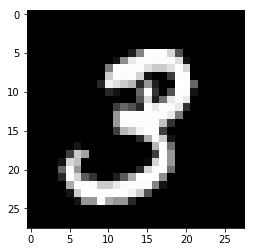

In [10]:
# Display an image read in from the CSV
# testFeatureVectorsConvoFormat values are: [2, 0, 9, 0, 3, 7, ...]
pixels = mnist.train.images[1].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

In [11]:
# Define Tensorflow graph
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
Y_ = tf.placeholder(tf.float32, [None, 10])
lr = tf.placeholder(tf.float32)
pkeep = tf.placeholder(tf.float32)

K = 6  # first convolutional layer output depth
L = 12  # second convolutional layer output depth
M = 24  # third convolutional layer
N = 200  # fully connected layer (softmax)

W1 = tf.Variable(tf.truncated_normal([6, 6, 1, K], stddev=0.1))  # 6x6 patch, 1 input channel, K output channels
B1 = tf.Variable(tf.constant(0.1, tf.float32, [K]))
W2 = tf.Variable(tf.truncated_normal([5, 5, K, L], stddev=0.1))
B2 = tf.Variable(tf.constant(0.1, tf.float32, [L]))
W3 = tf.Variable(tf.truncated_normal([4, 4, L, M], stddev=0.1))
B3 = tf.Variable(tf.constant(0.1, tf.float32, [M]))

W4 = tf.Variable(tf.truncated_normal([7 * 7 * M, N], stddev=0.1))
B4 = tf.Variable(tf.constant(0.1, tf.float32, [N]))

W5 = tf.Variable(tf.truncated_normal([N, 10], stddev=0.1))
B5 = tf.Variable(tf.constant(0.1, tf.float32, [10]))

# The model
stride = 1  # output is 28x28
Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)
stride = 2  # output is 14x14
Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)
stride = 2  # output is 7x7
Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)

# reshape the output from the third convolution for the fully connected layer
YY = tf.reshape(Y3, shape=[-1, 7 * 7 * M])

Y4 = tf.nn.relu(tf.matmul(YY, W4) + B4)
YY4 = tf.nn.dropout(Y4, pkeep)
Ylogits = tf.matmul(YY4, W5) + B5
Y = tf.nn.softmax(Ylogits)

In [12]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_mean(cross_entropy)*100

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
predictions = tf.argmax(Y, 1)

# training step, the learning rate is a placeholder
train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [15]:
# init
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

def getBatch(i, size, trainFeatures, trainLabels):
    startIndex = (i * size) % 55000
    endIndex = startIndex + size
    batch_X = trainFeatures[startIndex : endIndex]
    batch_Y = trainLabels[startIndex : endIndex]
    return batch_X, batch_Y

# You can call this function in a loop to train the model, 100 images at a time
def training_step(i):

    # training on batches of 100 images with 100 labels
    size = 100
    batch_X, batch_Y = getBatch(i, size, trainFeatureVectorsConvoFormat, ohTrainLabelsNdarray)

    # learning rate decay
    max_learning_rate = 0.003
    min_learning_rate = 0.0001
    decay_speed = 2000.0
    learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed)

    # compute training values
    if i % 100 == 0:
        '''
        When we sess.run here, we are calculating the accuracy and cross_entropy of the model on batch_X and batch_Y (ie. on 100 pieces of data)
        '''
        a, c = sess.run([accuracy, cross_entropy], {X: batch_X, Y_: batch_Y, pkeep: 1.0})
        print(str(i) + ": training accuracy:" + str(a) + " training loss: " + str(c) + " (lr:" + str(learning_rate) + ")")

    # the backpropagation training step
    sess.run(train_step, {X: batch_X, Y_: batch_Y, lr: learning_rate, pkeep: 0.75})

# Run number of iterations training the NN    
for i in range(1001):
    training_step(i)

0: training accuracy:0.07 training loss: 265.949 (lr:0.003)
100: training accuracy:0.95 training loss: 10.6128 (lr:0.0028585653310520707)
200: training accuracy:0.98 training loss: 7.41285 (lr:0.0027240285123042826)
300: training accuracy:0.97 training loss: 9.96212 (lr:0.0025960531316326675)
400: training accuracy:0.98 training loss: 6.79216 (lr:0.0024743191839261473)
500: training accuracy:0.99 training loss: 4.52627 (lr:0.002358522270907074)
600: training accuracy:0.98 training loss: 6.08006 (lr:0.002248372839976982)
700: training accuracy:0.98 training loss: 8.15674 (lr:0.002143595460184269)
800: training accuracy:0.98 training loss: 6.0382 (lr:0.002043928133503354)
900: training accuracy:0.99 training loss: 2.64279 (lr:0.001949121639703143)
1000: training accuracy:1.0 training loss: 1.52968 (lr:0.0018589389131666372)


In [16]:
# Print the test accuracy on hold out data
a, c = sess.run([accuracy, cross_entropy], {X: testFeatureVectorsConvoFormat, Y_: ohTestLabelsNdarray, pkeep: 1.0})
print("\n ********* test accuracy:" + str(a) + " test loss: " + str(c))


 ********* test accuracy:0.9841 test loss: 4.41542


In [23]:
p = sess.run([predictions], {X: testFeatureVectorsConvoFormat, pkeep: 1.})

In [24]:
p

[array([7, 2, 1, ..., 4, 5, 6])]

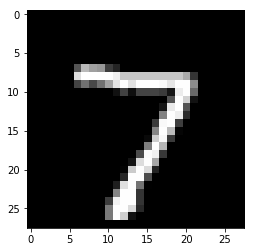

In [25]:
pixels = mnist.test.images[0].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

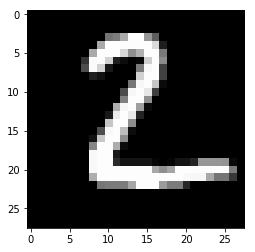

In [26]:
pixels = mnist.test.images[1].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

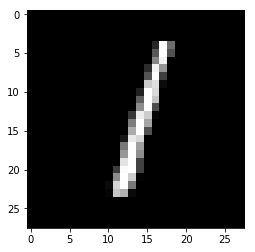

In [27]:
pixels = mnist.test.images[2].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()